In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime, date 
import warnings 
warnings.filterwarnings('ignore')

# 0: Load data

In [248]:
df = pd.read_csv('data/03-employee_retention_data.csv')

In [249]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [250]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


# 1. Retentation per company per day
## 1.1 Data manipulation and EDA

In [293]:
df['quit'] = np.where(df['quit_date'].isnull(), 1,0) 
#df['newcol'] = df.groupby('company_id')['salary'].transform('mean')
#df['salary'].fillna(df.groupby('company_id')['salary'].transform('mean'), inplace=True)

In [295]:
df.head()

In [175]:
df_r = df.groupby(['company_id', 'join_date'])['employee_id'].count().to_frame().reset_index()
df_q = df.groupby(['company_id', 'quit_date'])['employee_id'].count().to_frame().reset_index()

In [176]:
df_n = df_r.merge(df_q, left_on = ['company_id', 'join_date'], right_on = ['company_id', 'quit_date'], how = 'outer')

In [177]:
df_n.head()

,company_id,join_date,employee_id_x,quit_date,employee_id_y
0,1,2011-01-24,25.0,NaN,NaN
1,1,2011-01-25,2.0,NaN,NaN
2,1,2011-01-26,2.0,NaN,NaN
3,1,2011-01-31,30.0,NaN,NaN
4,1,2011-02-01,7.0,NaN,NaN


In [178]:
df_n.columns = ['company_id', 'date_time', 'join_num', 'quit_date', 'quit_num']
df_n['quit_num'].fillna(0, inplace = True)
df_n['join_num'].fillna(0, inplace = True)

In [179]:
df_n['quit_num'] = df_n.groupby('company_id')['quit_num'].cumsum()
df_n['join_num'] = df_n.groupby('company_id')['join_num'].cumsum()
df_n['retain_num'] = df_n['join_num']-df_n['quit_num'] 

In [180]:
df_n.head()

,company_id,date_time,join_num,quit_date,quit_num,retain_num
0,1,2011-01-24,25.0,NaN,0.0,25.0
1,1,2011-01-25,27.0,NaN,0.0,27.0
2,1,2011-01-26,29.0,NaN,0.0,29.0
3,1,2011-01-31,59.0,NaN,0.0,59.0
4,1,2011-02-01,66.0,NaN,0.0,66.0


In [181]:
df_n.company_id.nunique()

12

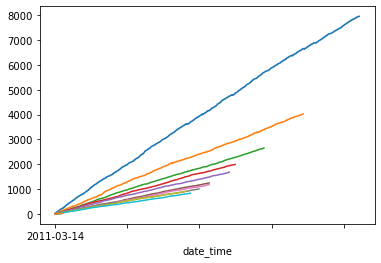

In [182]:
for i in df_n.company_id.unique():
    df_com = df_n[df_n['company_id'] ==i].groupby('date_time')['retain_num'].max()
    df_com.plot()

## 1.2 Feature engineering

In [183]:
df_n.head()

,company_id,date_time,join_num,quit_date,quit_num,retain_num
0,1,2011-01-24,25.0,NaN,0.0,25.0
1,1,2011-01-25,27.0,NaN,0.0,27.0
2,1,2011-01-26,29.0,NaN,0.0,29.0
3,1,2011-01-31,59.0,NaN,0.0,59.0
4,1,2011-02-01,66.0,NaN,0.0,66.0


In [186]:
df_n['month'] = pd.to_datetime(df_n['date_time'], errors = 'coerce').dt.month
df_n['day'] = pd.to_datetime(df_n['date_time'], errors = 'coerce').dt.day
df_n['year'] = pd.to_datetime(df_n['date_time'], errors = 'coerce').dt.year
df_n['date_time'] = pd.to_datetime(df_n['date_time'], errors = 'coerce')

In [200]:
df_n.head()
df_n.dropna(inplace=True)

## 1.3 Modeling 
### 1.3.1 Prepare data

In [201]:
X = df_n[['company_id','month', 'day', 'year']]
y = df_n['retain_num']

In [202]:
# training test spliting
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0)

### 1.3.2 Train model

In [203]:
# from sklearn.linear_model import LinearRegression
# linreg = LinearRegression(normalize = True)
# linreg.fit(X_train, y_train)
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg.fit(X_train, y_train)

RandomForestRegressor()

In [209]:
y_pred = rfreg.predict(X_test)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test,y_pred))


36.96540000000001


array([5014., 3043., 3937.,  495.,  254., 2221., 2009.,  405., 6880.,
       6794., 2488., 2873., 1547.,  849., 7216., 2432.,  622., 1630.,
       6825., 3365., 1052., 1838., 2478., 5745., 3560.,  220., 2460.,
       1854., 5366., 2434.,  834., 6026., 6360., 7745.,  787.,  560.,
       1775.,  686., 1458., 2467., 2173., 3601.,  827., 1890., 4742.,
       1643., 1507., 2312.,  301., 5553., 1725., 7162., 1206., 6631.,
       6456., 2085., 2418., 7255., 2095., 1085., 4744., 3680., 1451.,
        594., 1382., 7868., 1963.,  621., 3462., 4712., 6603., 4141.,
        964.,  211., 7315., 1702., 3279., 5487.,  556., 1209., 1325.,
       2451.,  705., 1844., 2448., 2343.,  443., 6892., 1368., 3855.,
       1863.,  794.,  913.,  712., 7414.,  458., 3887.,  244., 3996.,
       1165.])

In [211]:
def MAPE(y_test, y_pred):
    result = 0 
    for i in range(len(y_test)):
        result += abs(y_test[i]-y_pred[i])/y_pred[i]
    return result/len(y_test)
print(MAPE(np.array(y_test), y_pred))

0.029741638580895114


# 2. predict quit or not
## 2.1 Data manipulation 

In [253]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,1
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


In [254]:
df['join_date'] = pd.to_datetime(df['join_date'], errors = 'coerce')
df['year'] = df['join_date'].dt.year
df['month'] = df['join_date'].dt.month
df['day'] = df['join_date'].dt.day

## 2.2 EDA 

In [255]:
for col in df.columns:
    print(df[col].nunique())

24702
12
6
31
367
995
664
2
5
12
31


In [256]:
df.describe()

,employee_id,company_id,seniority,salary,quit,year,month,day
count,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478,0.453081,2012.995709,6.494899,15.874666
std,288909.026101,2.700011,8.089520,76058.184573,0.497804,1.395940,3.401531,8.840594
min,36.000000,1.000000,1.000000,17000.000000,0.000000,2011.000000,1.000000,1.000000
25%,250133.750000,1.000000,7.000000,79000.000000,0.000000,2012.000000,4.000000,8.000000
50%,500793.000000,2.000000,14.000000,123000.000000,0.000000,2013.000000,6.000000,16.000000
75%,753137.250000,5.000000,21.000000,187000.000000,1.000000,2014.000000,9.000000,23.000000
max,999969.000000,12.000000,99.000000,408000.000000,1.000000,2015.000000,12.000000,31.000000


In [257]:
df.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'quit', 'year', 'month', 'day'],
      dtype='object')

In [258]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['dept_le'] = le.fit_transform(df['dept'])

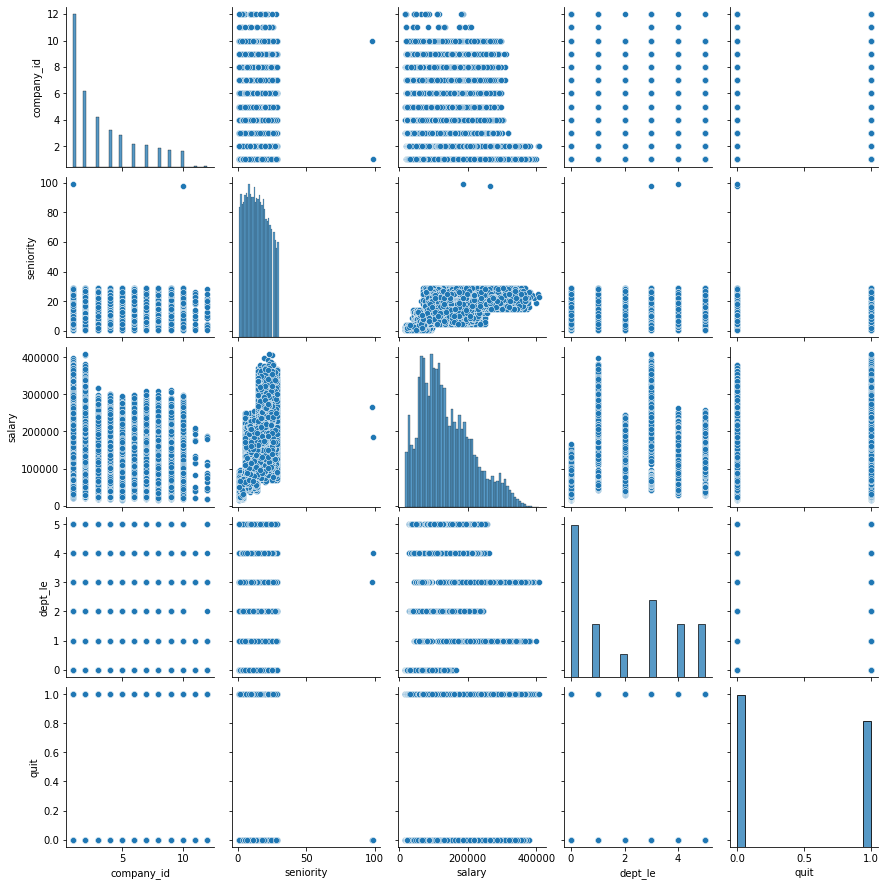

In [220]:
sns.pairplot(df[['company_id', 'seniority', 'salary','dept_le', 'quit']])

In [259]:
df = df[df['seniority']< 50]

<AxesSubplot:xlabel='company_id'>

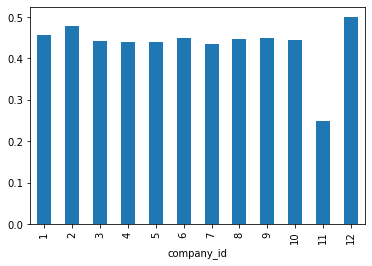

In [260]:
# company_id
df_company = df.groupby('company_id')['quit'].mean()
df_company.plot.bar()

<AxesSubplot:xlabel='dept'>

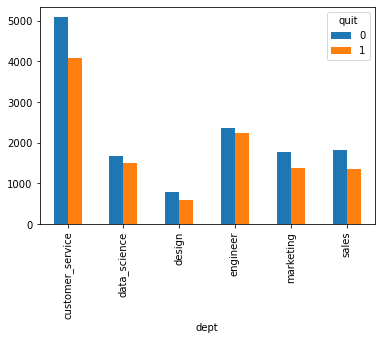

In [261]:
# dept 
pd.crosstab(df['dept'], df['quit']).plot.bar()

<AxesSubplot:xlabel='salary_group'>

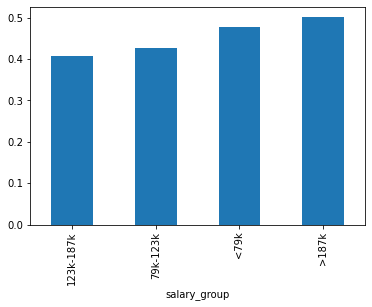

In [262]:
# salary 
df['salary_group'] = '123k-187k'
df.loc[df['salary']>187000, 'salary_group'] = '>187k'
df.loc[df['salary']<123000, 'salary_group'] = '79k-123k'
df.loc[df['salary']<79000, 'salary_group'] = '<79k'
df.groupby('salary_group')['quit'].mean().plot.bar()

<AxesSubplot:xlabel='senior_group'>

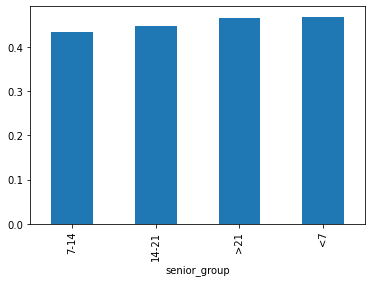

In [292]:
# seniority
df['senior_group'] = '14-21'
df.loc[df['seniority']>21, 'senior_group'] = '>21'
df.loc[df['seniority']<14, 'senior_group'] = '7-14'
df.loc[df['seniority']<7, 'senior_group'] = '<7'
df.groupby('senior_group')['quit'].mean().sort_values(ascending = True).plot.bar()

<AxesSubplot:xlabel='year'>

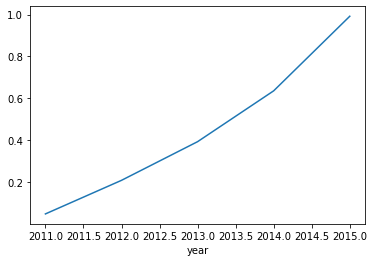

In [275]:
# Year
# df.groupby('year')['quit'].mean().plot()
df.groupby('year')['quit'].mean().plot()

## 2.3 Prepare data

In [264]:
df= pd.get_dummies(df, columns = ['dept','salary_group',
       'senior_group'])

In [265]:
df.columns

Index(['employee_id', 'company_id', 'seniority', 'salary', 'join_date',
       'quit_date', 'quit', 'year', 'month', 'day', 'dept_le',
       'dept_customer_service', 'dept_data_science', 'dept_design',
       'dept_engineer', 'dept_marketing', 'dept_sales',
       'salary_group_123k-187k', 'salary_group_79k-123k', 'salary_group_<79k',
       'salary_group_>187k', 'senior_group_14-21', 'senior_group_7-14',
       'senior_group_<7', 'senior_group_>21'],
      dtype='object')

In [267]:
X = df[['company_id', 'seniority', 'salary', 'year', 'month', 'day','dept_customer_service', 'dept_data_science',
       'dept_design', 'dept_engineer', 'dept_marketing', 'dept_sales','salary_group_123k-187k', 'salary_group_79k-123k', 'salary_group_<79k',
       'salary_group_>187k', 'senior_group_14-21', 'senior_group_7-14',
       'senior_group_<7', 'senior_group_>21']]
y = df['quit']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0)

## 2.4 Model

In [268]:
# train model
from sklearn.ensemble import RandomForestClassifier 
clf_rf = RandomForestClassifier(n_estimators = 100) 
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      2706
           1       0.79      0.71      0.75      2234

    accuracy                           0.79      4940
   macro avg       0.79      0.78      0.78      4940
weighted avg       0.79      0.79      0.78      4940



<AxesSubplot:>

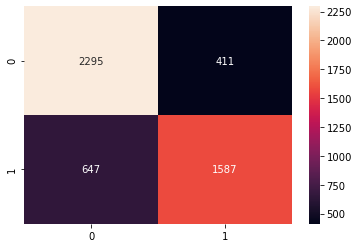

In [276]:
# metric F1_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc 
y_pred_clf = clf_rf.predict(X_test) 
print(classification_report(y_test, y_pred_clf))

cm = confusion_matrix(y_test, y_pred_clf)
sns.heatmap(cm, annot= True, fmt ='d')

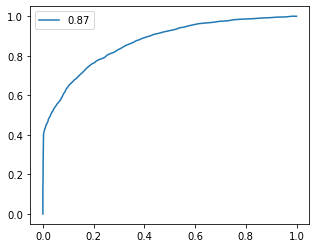

In [285]:
y_pred_prob = clf_rf.predict_proba(X_test)
fpr, tpr,_ = roc_curve(y_test, y_pred_prob[:,1])
roc_auc_lr = auc(fpr, tpr)
plt.figure(figsize = (5,4))
plt.plot(fpr, tpr, label = np.round(roc_auc_lr,2))
plt.legend()


<AxesSubplot:>

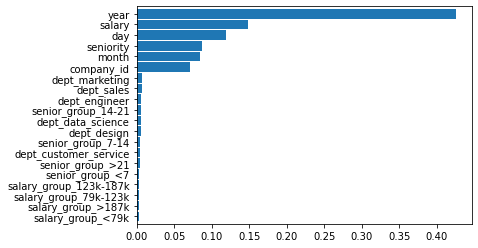

In [270]:
# feature importance 
features = np.array(X.columns)
feature_importance = pd.Series(clf_rf.feature_importances_, index = features).sort_values(ascending=True)
feature_importance.plot.barh(width = 0.9)

In [288]:
# tuning parameters 
from sklearn.model_selection import GridSearchCV
paras = {'n_estimators':[100,200,400], 'max_depth': [10,15,20], 'min_samples_split': [20,40]}

grid_search = GridSearchCV(clf_rf, param_grid = paras, scoring = 'f1', cv = 5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 400}


              precision    recall  f1-score   support

           0       0.80      0.85      0.82      2706
           1       0.80      0.74      0.77      2234

    accuracy                           0.80      4940
   macro avg       0.80      0.79      0.79      4940
weighted avg       0.80      0.80      0.80      4940



<AxesSubplot:>

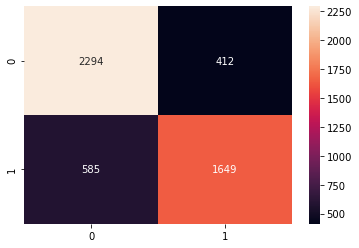

In [290]:
clf_rf = RandomForestClassifier(max_depth=10, min_samples_split= 20, n_estimators= 400) 
clf_rf.fit(X_train, y_train)
y_pred_clf = clf_rf.predict(X_test) 
print(classification_report(y_test, y_pred_clf))

cm = confusion_matrix(y_test, y_pred_clf)
sns.heatmap(cm, annot= True, fmt ='d')

# 3. Insights and Conclusion

According to the data analysis, the join time, salary and seniority are three important factors determining the quit of employee. Specific insights are as follows:
- The quit ratio increase with the year, it can be because the hiring environment are different but more infos are needed to draw conclusion. 
- People with high and low salary are more likely to quit, and the quit ratio for people with salary in 123k-187k is lowest. Company can try to adjust the method of salary division to decrease the quit possibility.
- People with seniority of 7-14 years are less likely to quit. Company can hire more people in this category. 